# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The shape of the whole state looks like:',states.shape)
print('The whole state looks like:',states)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The shape of the whole state looks like: (2, 24)
The whole state looks like: [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.65278625 -1.5        -0.          0.
   6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.4669857  -1.5         0.          0.
  -6.83172083  6

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# for i in range(5):                                         # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Define classes and functions here directly in the notebook rather than in separate files to make it easier to modify

# Import Packages

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import namedtuple, deque
import random
import copy
import sys
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


# add path to my source files
sys.path.insert(0, '/home/workspace/python/src/')
from workspace_utils import active_session # prevent dropped notebook connection
use_cuda = torch.cuda.is_available()

## Seed RNG

In [8]:
# seed rng
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

## OUNoise Action Space Noise

In [9]:
class OUActionNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state
        

## Gaussian Parameter Space Noise

In [10]:
class AdaptiveParamNoiseSpec(object):
    def __init__(self, initial_stddev=0.1, desired_action_stddev=0.2, adaptation_coefficient=1.01):
        """
        Note that initial_stddev and current_stddev refer to std of parameter noise, 
        but desired_action_stddev refers to (as name notes) desired std in action space
        """
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adaptation_coefficient = adaptation_coefficient

        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            # Decrease stddev.
            self.current_stddev /= self.adaptation_coefficient
        else:
            # Increase stddev.
            self.current_stddev *= self.adaptation_coefficient

    def get_stats(self):
        stats = {
            'param_noise_stddev': self.current_stddev,
        }
        return stats

    def __repr__(self):
        fmt = 'AdaptiveParamNoiseSpec(initial_stddev={}, desired_action_stddev={}, adaptation_coefficient={})'
        return fmt.format(self.initial_stddev, self.desired_action_stddev, self.adaptation_coefficient)

def ddpg_distance_metric(actions1, actions2):
    """
    Compute "distance" between actions taken by two policies at the same states
    Expects numpy arrays
    """
    diff = actions1-actions2
    mean_diff = np.mean(np.square(diff), axis=0)
    dist = np.sqrt(np.mean(mean_diff))
    return dist


def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
           target_param.data.copy_(param.data)

## Replay Buffer (for storing shared experience tuples)

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k = self.batch_size)
        
        states = [torch.from_numpy(np.vstack([e.states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions = [torch.from_numpy(np.vstack([e.actions[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        rewards = [torch.from_numpy(np.vstack([e.rewards[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states = [torch.from_numpy(np.vstack([e.next_states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        dones = [torch.from_numpy(np.vstack([e.dones[index] for e in experiences if e is not None]).astype(np.uint8)).float().to(device) for index in range(num_agents)]
        
        return (states,actions,rewards,next_states,dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
        
        

## Neural Network Architecture

In [12]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
#         if len(state.shape)==1:
#             state = torch.unsqueeze(state,dim=0)            
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, num_agents, state_size, action_size, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            num_agents (int): Number of agents sharing the replay buffer
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear((state_size+action_size)*num_agents, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = torch.cat((state, action.float()), dim=1)
        x = self.bn1(F.leaky_relu(self.fc1(xs)))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)


## DDPG Agent

In [13]:
### Hyperparameters
TAU = 8e-2              # for soft update of target parameters
LR_ACTOR = 5e-4         # learning rate of the actor 
LR_CRITIC = 5e-3        # learning rate of the critic
WEIGHT_DECAY = 0     # L2 weight decay

### New parameters
UPDATE_EVERY = 5       # interval to update target networks
NUM_UPDATES = 1        # times to update target network each interval

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, agent_index, total_agents):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            agent_index (int): index of this agent instance
            total_agents (int): total number of agents contributing to memory
        """
        self.state_size = state_size
        self.action_size = action_size
        
        self.learn_counter = 0
        self.agent_index = agent_index
        self.total_agents = total_agents

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_perturbed = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(total_agents, state_size, action_size).to(device)
        self.critic_target = Critic(total_agents, state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # ensure target network weights initially match local
        self.soft_update(self.actor_target, self.actor_local, 1)
        self.soft_update(self.actor_perturbed, self.actor_local, 1)
        self.soft_update(self.critic_target, self.critic_local, 1)

        # Noise process
        self.noise = OUActionNoise(action_size)
        

    def act(self, state, noise, param):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            if param is not None:
                action = self.actor_perturbed(state).cpu().data.numpy()
            else:
                action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if noise > 0:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        self.learn_counter = 0
        
    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor_local)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name: 
                pass 
            param = params[name]
            random = torch.randn(param.shape)
            if use_cuda:
                random = random.cuda()
            param += random * param_noise.current_stddev

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        self.learn_counter += 1
        states, actions, rewards, next_states, dones = experiences
        
        # combine states and actions from all active agents
        all_states = torch.cat(states, dim=1).to(device)
        all_next_states = torch.cat(next_states, dim=1).to(device)
        all_actions = torch.cat(actions, dim=1).to(device)
            
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_actions = [actions[ii].clone() for ii in range(self.total_agents)]
        next_actions[self.agent_index] = self.actor_target(next_states[self.agent_index])
        all_next_actions = torch.cat(next_actions, dim=1).to(device)
        Q_targets_next = self.critic_target(all_next_states,all_next_actions)
        
        # Compute Q targets
        Q_targets = rewards[self.agent_index] + (gamma * Q_targets_next * (1-dones[self.agent_index]))
        
        # Compute critic loss
        Q_expected = self.critic_local(all_states, all_actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = [actions[ii].clone() for ii in range(self.total_agents)]
        actions_pred[self.agent_index] = self.actor_local(states[self.agent_index])
        all_actions_pred = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic_local(all_states, all_actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- # 
        # -> option to update multiple times per learn
        if (self.learn_counter % UPDATE_EVERY == 0):
            for n in range(NUM_UPDATES):
                self.soft_update(self.critic_local, self.critic_target, TAU)
                self.soft_update(self.actor_local, self.actor_target, TAU)                  
                   

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    

## Multi-Agent DDPG Player Object

In [14]:
### Hyperparameters
GAMMA = 0.99            # discount factor
LEARN_EVERY = 1         # interval to update local networks
NUM_LEARNS = 1          # times to update local network each interval
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 260        # minibatch size

class MADDPG:
    def __init__(self, state_size, action_size, total_agents):
        super(MADDPG, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        self.total_agents = total_agents
        self.step_counter = 0

        # memory buffer for agents
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        # create two agents
        self.maddpg_agent = [Agent(state_size,action_size,ii, total_agents) for ii in range(total_agents)]


    def act(self, obs_all_agents, noise, param):
        """get actions from all agents in the MADDPG object"""   
        actions = np.zeros([self.total_agents, self.action_size])
        for ii, agent in enumerate(self.maddpg_agent):
            actions[ii,:] = agent.act(obs_all_agents[ii],noise,param)
        return actions


    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.buffer.add(states, actions, rewards, next_states, dones)
        self.step_counter += 1

        # Learn at specified interval, if enough samples are available in memory
        # -> option to learn multiple times per interval
        if (len(self.buffer) > BATCH_SIZE) and (self.step_counter % LEARN_EVERY == 0):
            for _ in range(NUM_LEARNS):
                experiences = self.buffer.sample()
                for agent in self.maddpg_agent:
                    agent.learn(experiences, GAMMA)
            
    def save(self):
        """ store dictionary of weights """
        for ii, agent in enumerate(self.maddpg_agent):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_agent' + str(ii) + '_final.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_agent' + str(ii) + '_final.pth')
            
    def reset(self):
        self.step_counter = 0
        for agent in self.maddpg_agent:
            agent.reset()
            

In [15]:
# initialize Multi-DDPG Agent object
maddpg = MADDPG(state_size, action_size, num_agents)
actors = [ddpg_agent.actor_local for ddpg_agent in maddpg.maddpg_agent]
critics = [ddpg_agent.critic_local for ddpg_agent in maddpg.maddpg_agent]
print(actors)
print(critics)

[Actor(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
), Actor(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)]
[Critic(
  (fc1): Linear(in_features=52, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, moment

# Self-Play Training Function

In [16]:
def train_maddpg(n_episodes=2000, max_t=1000, print_every=100):
    param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05,desired_action_stddev=0.3, adaptation_coefficient=1.05)
    scores_deque = deque(maxlen=print_every)
    score_list = []
    ACTION_NOISE = 1
    for i_episode in range(1, n_episodes+1):
        t = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        maddpg.reset()
        scores = np.zeros(num_agents)
#         maddpg.maddpg_agent[0].perturb_actor_parameters(param_noise)
#         maddpg.maddpg_agent[1].perturb_actor_parameters(param_noise)
        while True:
            t += 1
            actions = maddpg.act(states,ACTION_NOISE,None)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += rewards
            maddpg.step(states,actions,rewards,next_states,dones)
            states = next_states
            if np.any(dones):
                break 
        
        # Update parameter noise stddev for each actor
#         if (len(maddpg.buffer) > BATCH_SIZE):
#             states, _, _, _, _ = maddpg.buffer.sample()
#             index = np.random.random_integers(low=0, high=(BATCH_SIZE-1))
#             states = np.array([np.asarray(states[0][index]),np.asarray(states[1][index])])
#             actions_perturbed = maddpg.act(states,0,param_noise)
#             actions_unperturbed = maddpg.act(states,0,None)
#             ddpg_dist = ddpg_distance_metric(actions_perturbed, actions_unperturbed)
#             param_noise.adapt(ddpg_dist)
        
        # Bookkeep scores each episode
        max_score = np.max(scores)                # mean score across all agents
        scores_deque.append(max_score)
        score_list.append(max_score)
        mean_score = np.mean(scores_deque)  # mean score across (100) episodes
        
        # Print progress and store checkpoints each episode
        print('\rEpisode {}\tAverage Score: {:.4f}\tMax Score: {:.4f}\tMax T: {}'.format(i_episode, mean_score, max_score, t), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, mean_score))
            
        # Record final data once completion targets reached (Average over 30 for 100 consecutive episodes)
        if mean_score >= 0.5 and i_episode >= 100:
            print('\rEnvironment solved in {} episodes, mean score: {:.4f}'.format(i_episode, mean_score))
            maddpg.save()
            break
            
    return score_list

Episode 100	Average Score: 0.0068	Max Score: 0.0000	Max T: 14
Episode 200	Average Score: 0.0181	Max Score: 0.0000	Max T: 14
Episode 300	Average Score: 0.0333	Max Score: 0.0000	Max T: 14
Episode 400	Average Score: 0.0465	Max Score: 0.0000	Max T: 14
Episode 500	Average Score: 0.0551	Max Score: 0.1000	Max T: 33
Episode 600	Average Score: 0.0755	Max Score: 0.1000	Max T: 33
Episode 700	Average Score: 0.0865	Max Score: 0.1000	Max T: 30
Episode 800	Average Score: 0.0854	Max Score: 0.1000	Max T: 32
Episode 900	Average Score: 0.0859	Max Score: 0.1000	Max T: 52
Episode 1000	Average Score: 0.0857	Max Score: 0.1000	Max T: 31
Episode 1100	Average Score: 0.0972	Max Score: 0.1000	Max T: 31
Episode 1200	Average Score: 0.1029	Max Score: 0.1000	Max T: 300
Episode 1300	Average Score: 0.1267	Max Score: 0.1000	Max T: 303
Episode 1400	Average Score: 0.1516	Max Score: 0.3000	Max T: 109
Episode 1500	Average Score: 0.2103	Max Score: 0.5000	Max T: 204
Episode 1600	Average Score: 0.3107	Max Score: 0.6000	Max T: 

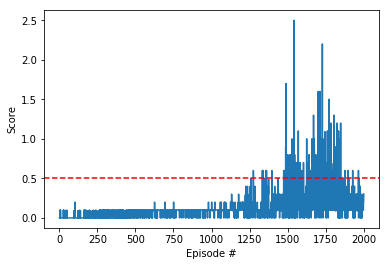

In [17]:
# train agent
seeding()

with active_session():
    scores = train_maddpg()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.axhline(y = 0.5, color = 'r', linestyle = '--')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()